<a href="https://colab.research.google.com/github/450586509/reinforcement-learning-practice/blob/master/05_explore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Run this if in COLAB
!pip install --upgrade https://github.com/Theano/Theano/archive/master.zip
!pip install --upgrade https://github.com/Lasagne/Lasagne/archive/master.zip
    
!wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week5_explore/bayes.py
!wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week5_explore/action_rewards.npy
!wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week5_explore/all_states.npy

     \ 29.8MB 9.4MB/s
  Created wheel for Theano: filename=Theano-1.0.4+unknown-cp36-none-any.whl size=2666479 sha256=4ff5139c8c911617637af78a90012c87e6572ab9ec33a2110c4178b0a8798369
  Stored in directory: /tmp/pip-ephem-wheel-cache-u6889ikg/wheels/33/73/96/0ed263c62a86e2485ea634e0d3ae8169d50fd66e3b252541db
Successfully built Theano
  Found existing installation: Theano 1.0.4+unknown
    Uninstalling Theano-1.0.4+unknown:
      Successfully uninstalled Theano-1.0.4+unknown
     \ 2.2MB 2.9MB/s
  Created wheel for Lasagne: filename=Lasagne-0.2.dev1-cp36-none-any.whl size=122750 sha256=a406887c1143b3c8c3601e9d7ebbc430b0f20eb944ed4b5bd1a6fdaf6cf5c846
  Stored in directory: /tmp/pip-ephem-wheel-cache-e5k97bfi/wheels/ca/4a/00/87f1777b229481fe76562df7c0cfb993bc88ed0cc37e3f0ed4
Successfully built Lasagne
  Found existing installation: Lasagne 0.2.dev1
    Uninstalling Lasagne-0.2.dev1:
      Successfully uninstalled Lasagne-0.2.dev1


In [0]:
from abc import ABCMeta, abstractmethod, abstractproperty
import enum

import numpy as np
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

import pandas
import math
from matplotlib import pyplot as plt
%matplotlib inline

## Bernouli Bandit问题
* 实现几个简单的探索策略，解决这个问题。
* bandit有K个动作，每一个动作有 $0 \le \theta_k \le 1$的概率获得reward=1的奖励，这个概率分布对于agent是未知的，但是固定不变的。agent的优化目标最小化下面的等式：$$\rho = T\theta^* - \sum_{t=1}^T r_t$$T是选择次数,$\theta^* = \max_k\{\theta_k\}$
* 


In [0]:
class BernoulliBandit:
    def __init__(self, n_actions=5):
        self._probs = np.random.random(n_actions)

    @property
    def action_count(self):
        return len(self._probs)

    def pull(self, action):
        if np.any(np.random.random() > self._probs[action]):
            return 0.0
        return 1.0

    def optimal_reward(self):
        """ Used for regret calculation
        """
        return np.max(self._probs)

    def step(self):
        """ Used in nonstationary version
        """
        pass

    def reset(self):
        """ Used in nonstationary version
        """
class AbstractAgent(metaclass=ABCMeta):
    def init_actions(self, n_actions):
        self._successes = np.zeros(n_actions)
        self._failures = np.zeros(n_actions)
        self._total_pulls = 0

    @abstractmethod
    def get_action(self):
        """
        Get current best action
        :rtype: int
        """
        pass

    def update(self, action, reward):
        """
        Observe reward from action and update agent's internal parameters
        :type action: int
        :type reward: int
        """
        self._total_pulls += 1
        if reward == 1:
            self._successes[action] += 1
        else:
            self._failures[action] += 1

    @property
    def name(self):
        return self.__class__.__name__


class RandomAgent(AbstractAgent):
    def get_action(self):
        return np.random.randint(0, len(self._successes))

In [0]:
###

#### epsilon-greedy agent

**for** $t = 1,2,...$ **do**

&nbsp;&nbsp; **for** $k = 1,...,K$ **do**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\hat\theta_k \leftarrow \alpha_k / (\alpha_k + \beta_k)$

&nbsp;&nbsp; **end for** 

&nbsp;&nbsp; $x_t \leftarrow argmax_{k}\hat\theta$ with probability $1 - \epsilon$ or random action with probability $\epsilon$

&nbsp;&nbsp; Apply $x_t$ and observe $r_t$

&nbsp;&nbsp; $(\alpha_{x_t}, \beta_{x_t}) \leftarrow (\alpha_{x_t}, \beta_{x_t}) + (r_t, 1-r_t)$

**end for**

Implement the algorithm above in the cell below:


In [0]:
class EpsilonGreedyAgent(AbstractAgent):
    def __init__(self, epsilon=0.01):
        self._epsilon = epsilon
    def best_action(self):
      max_p = -1
      best_action = -1
      for action, (a, b) in enumerate(zip(self._successes, self._failures)):
        if a + b == 0:
          p = 100000
        else:
          p = (1.0 * a) / (a + b)
        if max_p < p :
          max_p = p
          best_action = action
      if best_action == -1:
        best_action = np.random.choice(range(len(self._successes)))
      return best_action
          

    def get_action(self):
        # YOUR CODE HERE
        # best_action
        best_action = self.best_action()
        is_choice_random_action = np.random.choice([True, False], p=[self._epsilon, 1-self._epsilon])
        random_action = np.random.choice(range(len(self._successes)))
        if is_choice_random_action:
          return random_action
        return best_action

    @property
    def name(self):
        return self.__class__.__name__ + "(epsilon={})".format(self._epsilon)

### UCB Agent
Epsilon-greedy strategy heve no preference for actions. It would be better to select among actions that are uncertain or have potential to be optimal. One can come up with idea of index for each action that represents otimality and uncertainty at the same time. One efficient way to do it is to use UCB1 algorithm:

**for** $t = 1,2,...$ **do**

&nbsp;&nbsp; **for** $k = 1,...,K$ **do**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $w_k \leftarrow \alpha_k / (\alpha_k + \beta_k) + \sqrt{2log\ t \ / \ (\alpha_k + \beta_k)}$

&nbsp;&nbsp; **end for** 

&nbsp;&nbsp; **end for** 
 $x_t \leftarrow argmax_{k}w$

&nbsp;&nbsp; Apply $x_t$ and observe $r_t$

&nbsp;&nbsp; $(\alpha_{x_t}, \beta_{x_t}) \leftarrow (\alpha_{x_t}, \beta_{x_t}) + (r_t, 1-r_t)$

**end for**

__Note:__ in practice, one can multiply $\sqrt{2log\ t \ / \ (\alpha_k + \beta_k)}$ by some tunable parameter to regulate agent's optimism and wilingness to abandon non-promising actions.

More versions and optimality analysis - https://homes.di.unimi.it/~cesabian/Pubblicazioni/ml-02.pdf

In [0]:
class UCBAgent(AbstractAgent):
    def get_action(self):
      max_p = -1
      best_action = -1
      for action, (a, b) in enumerate(zip(self._successes, self._failures)):
        if a + b == 0:
          p = 1000000
        else:
          t = self._total_pulls + 1
          p = (1.0 * a) / (a + b) + pow((2 * math.log(t,2)) / (a + b) , 0.5)
        if max_p < p :
          max_p = p
          best_action = action
      if best_action == -1:
        best_action = np.random.choice(range(len(self._successes)))
      return best_action

   

### Thompson sampling

UCB1 algorithm does not take into account actual distribution of rewards. If we know the distribution - we can do much better by using Thompson sampling:

**for** $t = 1,2,...$ **do**

&nbsp;&nbsp; **for** $k = 1,...,K$ **do**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Sample $\hat\theta_k \sim beta(\alpha_k, \beta_k)$

&nbsp;&nbsp; **end for** 

&nbsp;&nbsp; $x_t \leftarrow argmax_{k}\hat\theta$

&nbsp;&nbsp; Apply $x_t$ and observe $r_t$

&nbsp;&nbsp; $(\alpha_{x_t}, \beta_{x_t}) \leftarrow (\alpha_{x_t}, \beta_{x_t}) + (r_t, 1-r_t)$

**end for**
 

More on Thompson Sampling:
https://web.stanford.edu/~bvr/pubs/TS_Tutorial.pdf

In [0]:
class ThompsonSamplingAgent(AbstractAgent):
    def get_action(self):
      theta_vals = []
      for a, b in zip(self._successes, self._failures):
        theta_vals.append(np.random.beta(a, b, size=1))
      best_action = np.argmax(theta_vals)
      return best_action


### 验证代码

In [0]:
def plot_regret(env, agents, n_steps=5000, n_trials=50):
    scores = {
        agent.name: [0.0 for step in range(n_steps)] for agent in agents
    }

    for trial in range(n_trials):
        env.reset()

        for a in agents:
            a.init_actions(env.action_count)

        for i in range(n_steps):
            optimal_reward = env.optimal_reward()

            for agent in agents:
                action = agent.get_action()
                reward = env.pull(action)
                agent.update(action, reward)
                scores[agent.name][i] += optimal_reward - reward

            env.step()  # change bandit's state if it is unstationary

    plt.figure(figsize=(17, 8))
    for agent in agents:
        plt.plot(np.cumsum(scores[agent.name]) / n_trials)

    plt.legend([agent.name for agent in agents])

    plt.ylabel("regret")
    plt.xlabel("steps")

    plt.show()

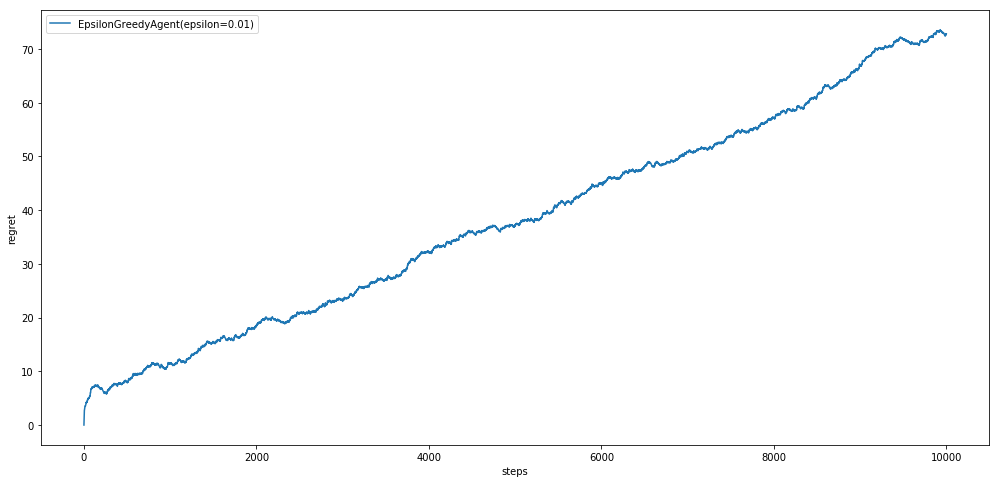

In [9]:
# Uncomment agents
agents = [
         EpsilonGreedyAgent()
         #UCBAgent()
         #ThompsonSamplingAgent()
]

plot_regret(BernoulliBandit(), agents, n_steps=10000, n_trials=10)

In [10]:
np.argmax([0,1,2,3,111,3])

4

In [11]:
np.random.choice(range(5))

3